In [248]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import warnings

In [249]:
#get data function
def get_data(file_path, start_year=None):
    df = pd.read_csv(file_path, sep=';', parse_dates=["time"])
    df.set_index("time", inplace=True)
    df.dropna(axis=1, how='all', inplace=True)

    if start_year:
        start_date = f"{start_year}-01-01"
        df = df.loc[start_date:].copy()

    return df

In [250]:
#read in the data files
csi_spot = get_data("../data/csi300_spot_csv.csv", 2017)
csi_futures = get_data("../data/csi300_futures_csv.csv", 2017)

snp_spot = get_data("../data/snp500_spot_csv.csv", 2017)
snp_futures = get_data("../data/snp500_futures_csv.csv", 2017)

csi_futures_badj = get_data("../data/csi300_futures_badj_csv.csv", 2017)
snp_futures_badj = get_data("../data/snp500_futures_badj_csv.csv", 2017)

rf_cn = get_data("../data/rf_cn.csv", 2017)
rf_us = get_data("../data/rf_us.csv", 2017)

In [251]:
#create df for stats
cn_stats = pd.DataFrame()

cn_stats['fut_close'] = csi_futures["close"]
cn_stats['spot_close'] = csi_spot["close"]
cn_stats['basis'] = csi_futures["close"] - csi_spot["close"]
cn_stats['norm_basis'] = cn_stats['basis'] / csi_spot["close"]
cn_stats['fut_ret'] = np.log(csi_futures['close']).diff()
cn_stats['spot_ret'] = np.log(csi_spot['close']).diff()
cn_stats['volume'] = csi_futures['Volume']
cn_stats = cn_stats[cn_stats['volume'] > 0]
cn_stats['open_interest'] = csi_futures['Futures Open Interest']
cn_stats["risk_free"] = rf_cn['close']
cn_stats["amihud_illiq"] = 1e6 * (abs(cn_stats['fut_ret']) / (cn_stats['volume'] * cn_stats['fut_close'] * 300))
cn_stats['abs_basis'] = abs(cn_stats['basis'])
cn_stats.dropna(inplace=True)

us_stats = pd.DataFrame()
us_stats['fut_close'] = snp_futures["close"]
us_stats['spot_close'] = snp_spot["close"]
us_stats['basis'] = snp_futures["close"] - snp_spot["close"]
us_stats['norm_basis'] = us_stats['basis'] / snp_spot["close"]
us_stats['fut_ret'] = np.log(snp_futures['close']).diff()
us_stats['spot_ret'] = np.log(snp_spot['close']).diff()
us_stats['volume'] = snp_futures['Volume']
us_stats = us_stats[us_stats['volume'] > 0]
us_stats['open_interest'] = snp_futures['Futures Open Interest']
us_stats["risk_free"] = rf_us['close']
us_stats["amihud_illiq"] = 1e6 * (abs(us_stats['fut_ret']) / (us_stats['volume'] * us_stats['fut_close'] * 50))
us_stats['abs_basis'] = abs(us_stats['basis'])
us_stats.dropna(inplace=True)


#cn_stats.to_csv('/Users/sebestyenhorvath/Projects/AWP/data/cn_stats.csv')
#us_stats.to_csv('/Users/sebestyenhorvath/Projects/AWP/data/us_stats.csv')


cn_stats_badj = pd.DataFrame()

cn_stats_badj['fut_close'] = csi_futures_badj["close"]
cn_stats_badj['spot_close'] = csi_spot["close"]
cn_stats_badj['basis'] = csi_futures_badj["close"] - csi_spot["close"]
cn_stats_badj['norm_basis'] = cn_stats_badj['basis'] / csi_spot["close"]
cn_stats_badj['fut_ret'] = np.log(csi_futures_badj['close']).diff()
cn_stats_badj['spot_ret'] = np.log(csi_spot['close']).diff()
cn_stats_badj['volume'] = csi_futures_badj['Volume']
cn_stats_badj = cn_stats_badj[cn_stats_badj['volume'] > 0]
cn_stats_badj['open_interest'] = csi_futures_badj['Futures Open Interest']
cn_stats_badj["risk_free"] = rf_cn['close']
cn_stats_badj["amihud_illiq"] = 1e6 * (abs(cn_stats_badj['fut_ret']) / (cn_stats_badj['volume'] * cn_stats_badj['fut_close'] * 300))
cn_stats_badj.dropna(inplace=True)

us_stats_badj = pd.DataFrame()

us_stats_badj['fut_close'] = snp_futures_badj["close"]
us_stats_badj['spot_close'] = snp_spot["close"]
us_stats_badj['basis'] = snp_futures_badj["close"] - snp_spot["close"]
us_stats_badj['norm_basis'] = us_stats_badj['basis'] / snp_spot["close"]
us_stats_badj['fut_ret'] = np.log(snp_futures_badj['close']).diff()
us_stats_badj['spot_ret'] = np.log(snp_spot['close']).diff()
us_stats_badj['volume'] = snp_futures_badj['Volume']
us_stats_badj = us_stats_badj[us_stats_badj['volume'] > 0]
us_stats_badj['open_interest'] = snp_futures_badj['Futures Open Interest']
us_stats_badj["risk_free"] = rf_us['close']
us_stats_badj["amihud_illiq"] = 1e6 * (abs(us_stats_badj['fut_ret']) / (us_stats_badj['volume'] * us_stats_badj['fut_close'] * 50))
us_stats_badj.dropna(inplace=True)

In [252]:
#calculate ohr and he
def calculate_rolling_ohr_he(df, window_size=60):

    ohr_list = []
    he_list = []
    dates_list = []

    for i in range(window_size, len(df)):
        window = df.iloc[i - window_size : i]

        Y = window['spot_ret']
        X = sm.add_constant(window['fut_ret'])

        model = sm.OLS(Y, X, missing='drop').fit()

        ohr_list.append(model.params['fut_ret'])
        he_list.append(model.rsquared)
        dates_list.append(window.index[-1])

    results_df = pd.DataFrame({
        'ohr': ohr_list,
        'he': he_list
    }, index=dates_list)

    return df.join(results_df)

cn_stats_badj = calculate_rolling_ohr_he(cn_stats_badj)
us_stats_badj = calculate_rolling_ohr_he(us_stats_badj)



In [253]:
#plottig stats

def plot_basis_stats(stats):
    fig, ax = plt.subplots(11,1, figsize=(12,22), sharex=True)
    ax[0].plot(stats.index, stats['spot_close'], label='Spot')
    ax[0].plot(stats.index, stats['fut_close'], label='Futures', alpha=0.8)
    ax[0].legend(); ax[0].set_title(f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} Index Spot and Futures (Currency)')

    ax[1].plot(stats.index, stats['basis'], label='Basis')
    ax[1].set_title(f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} Futures - Spot (Basis) (Currency)'); ax[1].axhline(0, color='k', lw=0.5)

    ax[2].plot(stats.index, stats['norm_basis']*100)
    ax[2].set_title(f"{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} Normalized Basis (%)"); ax[2].axhline(0, color='k', lw=0.5)

    ax[3].plot(stats.index, stats["fut_ret"]*100)
    ax[3].set_title(f"{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} % Change DoD in Futures Prices")

    ax[4].plot(stats.index, stats["spot_ret"]*100)
    ax[4].set_title(f"{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} % Change DoD in Spot Prices")

    ax[5].plot(stats.index, stats["open_interest"])
    ax[5].set_title(f"{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} Daily Open Interest on Futures")

    ax[6].plot(stats.index, stats["volume"])
    ax[6].set_title(f"{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} Daily Volume on Futures")

    ax[7].plot(stats.index, stats['risk_free'])
    ax[7].set_title(f"{'Chinese' if stats is cn_stats or stats is cn_stats_badj else 'US'} Risk Free Rate (%)")

    ax[8].plot(stats.index, stats['amihud_illiq'])
    ax[8].set_title(f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} Futures Amihud Illiquidity')

    ax[9].plot(stats.index, stats['ohr'])
    ax[9].set_title(f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} Optimal Hedge ratio (60 day window)')

    ax[10].plot(stats.index, stats['he'])
    ax[10].set_title(f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} Hedging Effectiveness (60 day window)')



    plt.show()


#plot_basis_stats(cn_stats_badj), plot_basis_stats(us_stats_badj)

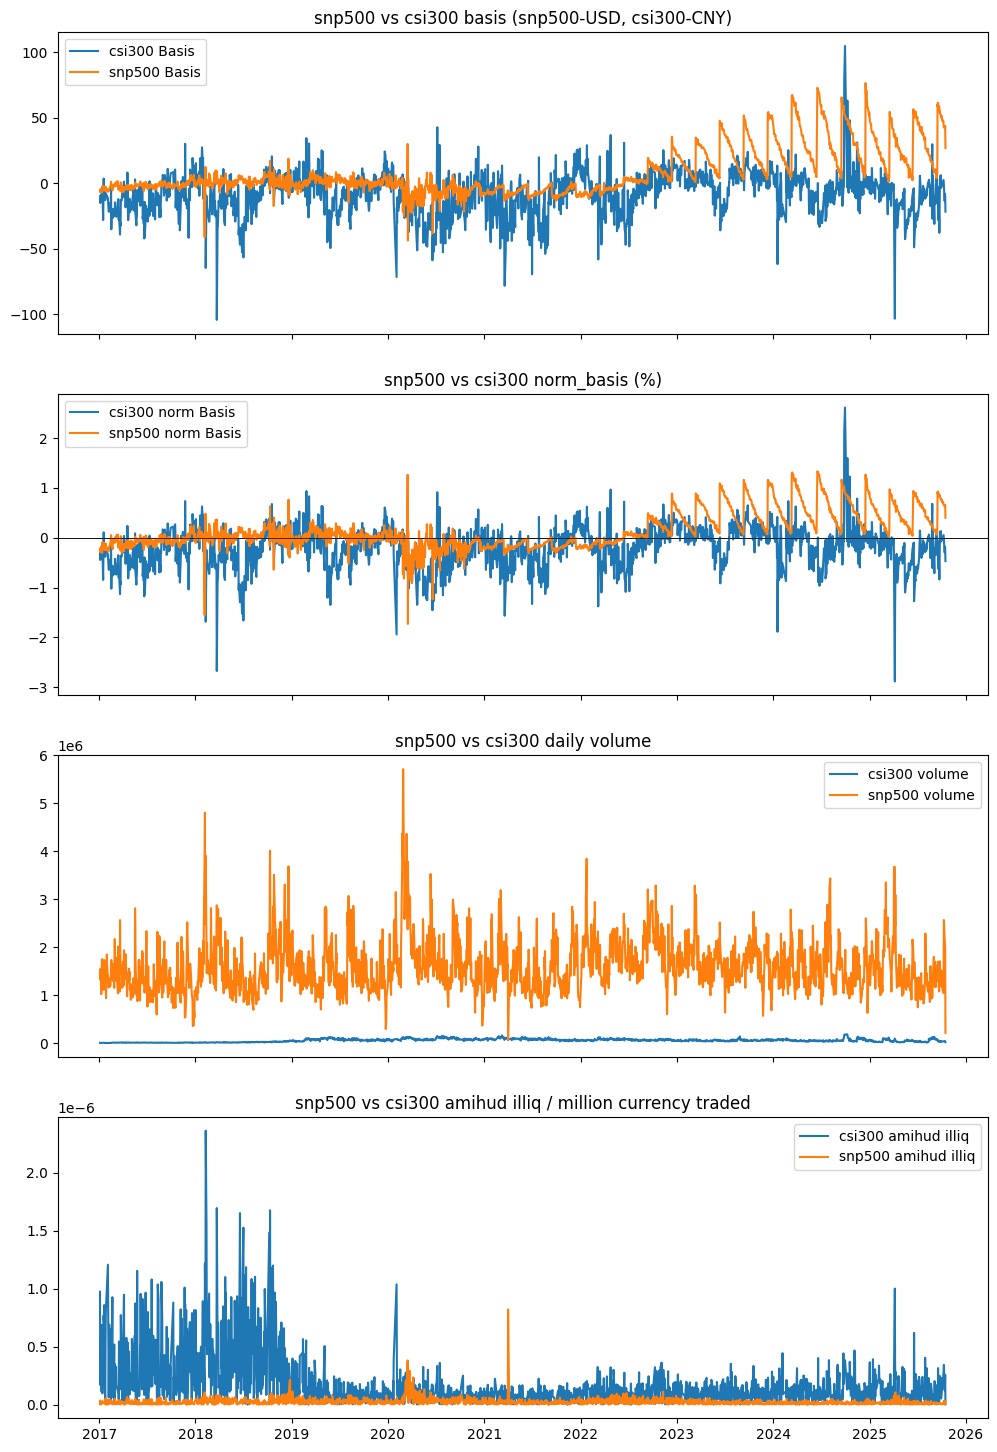

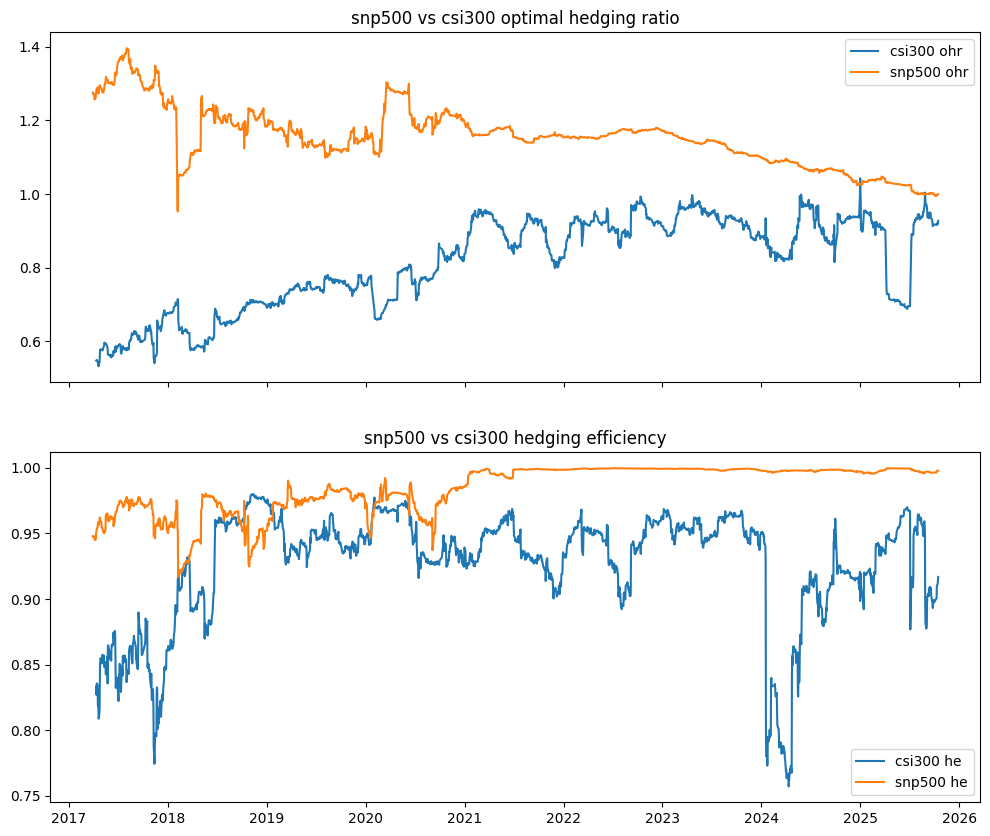

In [254]:
def plot_basis_comparison(cn_stats, us_stats):
    fig, ax = plt.subplots(4,1, figsize=(12,18), sharex=True)
    ax[0].plot(cn_stats.index, cn_stats['basis'], label='csi300 Basis')
    ax[0].plot(us_stats.index, us_stats['basis'], label='snp500 Basis')
    ax[0].set_title('snp500 vs csi300 basis (snp500-USD, csi300-CNY)'); ax[1].axhline(0, color='k', lw=0.5); ax[0].legend()

    ax[1].plot(cn_stats.index, cn_stats['norm_basis']*100, label='csi300 norm Basis')
    ax[1].plot(us_stats.index, us_stats['norm_basis']*100, label='snp500 norm Basis')
    ax[1].set_title('snp500 vs csi300 norm_basis (%)'); ax[1].axhline(0, color='k', lw=0.5); ax[1].legend()

    ax[2].plot(cn_stats.index, cn_stats['volume'], label='csi300 volume')
    ax[2].plot(us_stats.index, us_stats['volume'], label='snp500 volume')
    ax[2].set_title('snp500 vs csi300 daily volume'); ax[2].legend()

    ax[3].plot(cn_stats.index, cn_stats['amihud_illiq'], label='csi300 amihud illiq')
    ax[3].plot(us_stats.index, us_stats['amihud_illiq'], label='snp500 amihud illiq')
    ax[3].set_title('snp500 vs csi300 amihud illiq / million currency traded'); ax[3].legend()
 

plot_basis_comparison(cn_stats, us_stats)

def plot_hedging_comparison(cn_stats_badj, us_stats_badj):
    fig, ax = plt.subplots(2,1, figsize=(12,10), sharex=True)

    ax[0].plot(cn_stats_badj.index, cn_stats_badj['ohr'], label='csi300 ohr')
    ax[0].plot(us_stats_badj.index, us_stats_badj['ohr'], label='snp500 ohr')
    ax[0].set_title('snp500 vs csi300 optimal hedging ratio'); ax[0].legend()

    ax[1].plot(cn_stats_badj.index, cn_stats_badj['he'], label='csi300 he')
    ax[1].plot(us_stats_badj.index, us_stats_badj['he'], label='snp500 he')
    ax[1].set_title('snp500 vs csi300 hedging efficiency'); ax[1].legend()

plot_hedging_comparison(cn_stats_badj, us_stats_badj)



In [255]:
#summary df function
def summary(stats):
    def summary_series(s):
        return pd.Series({
            'mean': s.mean(), 'std': s.std(),
            'skew': s.skew(), 'kurt': s.kurtosis()
        })

    summary = pd.concat([
        summary_series(stats['fut_ret'].dropna()),
        summary_series(stats['basis'].dropna()),
        summary_series(stats['volume'].dropna()),
        summary_series(stats['open_interest'].dropna()),
        summary_series(stats['risk_free'].dropna()),
        summary_series(stats['amihud_illiq'].dropna()),
        summary_series(stats['ohr'].dropna()),
        summary_series(stats['he'].dropna())
        

    ], axis=1)

    summary.columns = [f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} fut_ret',
                       f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} basis',
                       f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} volume',
                       f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} open_interest',
                        f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} risk_free',
                        f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} amihud illiq',
                        f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} ohr',
                        f'{'Csi300' if stats is cn_stats or stats is cn_stats_badj else 'Snp500'} he']

    return summary.T

print(summary(us_stats_badj))
print(summary(cn_stats_badj))

                              mean           std      skew       kurt
Snp500 fut_ret        3.645130e-04  1.004527e-02 -0.476230  13.387679
Snp500 basis          5.302306e+02  1.550190e+02 -1.813177   2.059706
Snp500 volume         1.606552e+06  5.429529e+05  1.422528   4.243107
Snp500 open_interest  2.431479e+06  3.966477e+05  0.081903   0.269751
Snp500 risk_free      2.756250e+00  1.194675e+00 -0.067851  -1.126619
Snp500 amihud illiq   1.801662e-08  2.163335e-08  0.000000   0.000000
Snp500 ohr            1.154827e+00  7.871738e-02  0.326777   0.262602
Snp500 he             9.846287e-01  1.808119e-02 -1.207667   0.774435
                              mean           std      skew       kurt
Csi300 fut_ret        3.682267e-04  1.441377e-02 -0.411758   8.593706
Csi300 basis         -5.702623e+02  3.599666e+02 -0.268399  -1.407239
Csi300 volume         5.948561e+04  3.146052e+04  0.287865  -0.229622
Csi300 open_interest  7.374194e+04  3.712288e+04  0.537454   0.041973
Csi300 risk_free    

In [256]:

#check for stationary function (ADF)
warnings.filterwarnings("ignore")

def check_stationarity(df, column_name):

    result = adfuller(df[column_name].dropna())
    p_value = result[1]
    print(f'ADF statistic: {result[0]:.4f}')
    print(f'p-value: {p_value:.4f}')
    if p_value < 0.05:
        print(f"the {column_name + '_CSI300' if df is cn_stats else column_name + '_SNP500'} series is stationary (p < 0.05)")
    else:
        print(f"the {column_name + '_CSI300' if df is cn_stats else column_name + '_SNP500'} series is non-stationary (p > 0.05)")


In [257]:
# granger causality function
def run_granger_causality(df, variables, max_lag=5):
    print(f"testing relationship between: {variables[0]} and {variables[1]}, {'CSI300' if df is cn_stats else 'SNP500'}")
    
    data_for_test = df[variables].dropna()
    
    results = grangercausalitytests(data_for_test, maxlag=max_lag, verbose=False)
    
    print("Lag, p-value (F-test)")
    for lag in range(1, max_lag + 1):
        p_value = results[lag][0]['ssr_ftest'][1]
        print(f"{lag}, {p_value:.4f}")



In [258]:

#print them out
check_stationarity(cn_stats, 'abs_basis')
check_stationarity(cn_stats, 'amihud_illiq')
print('-'*40)


run_granger_causality(cn_stats, ['abs_basis', 'amihud_illiq'])
run_granger_causality(cn_stats, ['amihud_illiq', 'abs_basis'])


print('-'*40)
print('-'*40)
print('-'*40)


check_stationarity(us_stats, 'abs_basis')
check_stationarity(us_stats, 'amihud_illiq')
print('-'*40)

run_granger_causality(us_stats, ['abs_basis', 'amihud_illiq'])
run_granger_causality(us_stats, ['amihud_illiq', 'abs_basis'])
print('-'*40)


ADF statistic: -5.5242
p-value: 0.0000
the abs_basis_CSI300 series is stationary (p < 0.05)
ADF statistic: -3.0430
p-value: 0.0311
the amihud_illiq_CSI300 series is stationary (p < 0.05)
----------------------------------------
testing relationship between: abs_basis and amihud_illiq, CSI300
Lag, p-value (F-test)
1, 0.1743
2, 0.4436
3, 0.5873
4, 0.7392
5, 0.7111
testing relationship between: amihud_illiq and abs_basis, CSI300
Lag, p-value (F-test)
1, 0.7878
2, 0.4250
3, 0.4942
4, 0.1801
5, 0.1191
----------------------------------------
----------------------------------------
----------------------------------------
ADF statistic: -6.6893
p-value: 0.0000
the abs_basis_SNP500 series is stationary (p < 0.05)
ADF statistic: -6.2173
p-value: 0.0000
the amihud_illiq_SNP500 series is stationary (p < 0.05)
----------------------------------------
testing relationship between: abs_basis and amihud_illiq, SNP500
Lag, p-value (F-test)
1, 0.7038
2, 0.0066
3, 0.0191
4, 0.0210
5, 0.0233
testing re